# Forward model

In [58]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z
from src.projection import project_spatial, project, rotate
from src.interpolate import *

### Create volume

Text(0.5, 1.0, 'Volume_comp MIP')

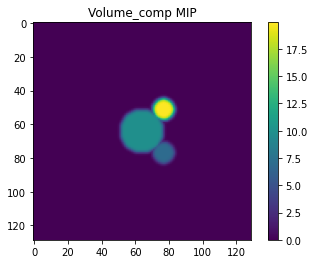

In [64]:
shape = np.array([129,129,129])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 2], [2, -2, 2]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

v = volume_comp(shape, dimensions, centres, radii, intensities)

mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Vol FFT slice')

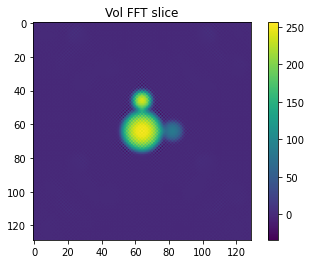

In [65]:
angles = np.array([0,0,np.pi/4])

v_slice = project_spatial(v, angles, dimensions, "tri")

plt.imshow(v_slice); plt.colorbar()
plt.title('Vol FFT slice')

Text(0.5, 1.0, 'Tri')

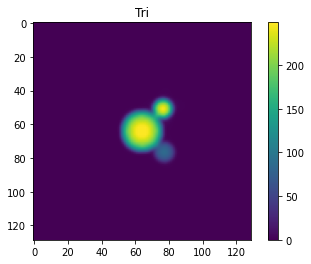

In [76]:
angles = np.array([0,0,np.pi/100])

slice_tri = project_spatial(v, angles, dimensions, "tri")

plt.imshow(slice_tri); plt.colorbar()
plt.title("Tri")

#([-50,350])

Text(0.5, 1.0, 'NN')

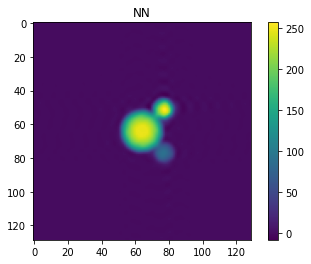

In [77]:
slice_nn = project_spatial(v, angles, dimensions, "nn")

plt.imshow(slice_nn); plt.colorbar()
plt.title("NN")